# Richdreamer How-to





The Richdreamer model is a text-to-3d model that used text inputs to generate high-quality 3d models.

To run the Richdreamer model, you are going to need access to a gpu. I requested access to use my university's supercomputer, which is available free to their students.

I connected to the computer using ssh and started an interactive session (python preinstalled).

System: Red Hat Linux 9.2\
GPU Used: NVIDIA Quadro RTX 6000


You can see if your school offers these services or use a cloud gpu using AWS, Azure, Google Cloud, etc.

## Initializing Conda

Make sure conda is set up on your gpu. If it already is, you can skip these steps.

In [ ]:
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh

In [ ]:
source ~/miniconda3/bin/activate
conda init # activate conda in current shell session
source ~/.bashrc

You might need to manually add Conda to your PATH if the conda command is not found while running "conda init."

In [ ]:
export PATH="~/miniconda3/bin:$PATH" # replace with you path to miniconda3/bin

source ~/.bashrc  # source shell profile to update current shell session
conda init
source ~/.bashrc  # source shell profile again

## Setting Paths

You have to reset these variables in your bash shell:

In [ ]:
# Replace with your GPU's compute capability. To find this, run "nvidia-smi"
# Search up the driver name
export TCNN_CUDA_ARCHITECTURES=70

# Replace with the path to your CUDA installation. To find this, run "which nvcc" and copy path before /bin.
# If right, it will have bin/ and lib64/ directories inside.
# For example, my output was "~/miniconda3/envs/myenv10/bin/nvcc"
export CUDA_HOME=~/miniconda3/envs/myenv10


export PATH=$CUDA_HOME/bin:$PATH
export LD_LIBRARY_PATH=$CUDA_HOME/lib64:$LD_LIBRARY_PATH

In [ ]:
source ~/.bashrc # reload shell configuration

## Setting up Directories



**You will need at least 40GB of memory to download the model repo and weights. Make sure your gpu has space for this!**

### Download Repo

We will first download the repo with the bash commands below. Navigate to the location you would like the repo to be.


In [ ]:
git clone https://github.com/modelscope/RichDreamer.git --recursive

SyntaxError: invalid syntax (<ipython-input-2-d7eab7228024>, line 1)

### Download Weights

Now, we will download the weights.

In [ ]:
python tools/download_nd_models.py

Now, we navigate to the directory we want the weights to go in.

**The tar weights file is large, so we will use "wget" with multiple retry and resume options. This prevents the file download from stopping due to network and processing errors.**

In [ ]:
mkdir -p pretrained_models/huggingface/hub && cd pretrained_models/huggingface/hub

# download weights with retries and resume partial downloads
wget --tries=100 --continue https://virutalbuy-public.oss-cn-hangzhou.aliyuncs.com/share/RichDreamer/models_sd_clip.tar.gz
tar -xvf models_sd_clip.tar.gz ./

Navigate back to the RichDreamer directory and check the file structure.

In [ ]:
cd .. # repeat as needed to get back to RichDreamer repo directory
tree ./pretrained_models

SyntaxError: invalid syntax (<ipython-input-3-1d46002bb16a>, line 1)

The tree command should display below:

In [ ]:
RichDreamer
|-- pretrained_models
    |-- Damo_XR_Lab
        |-- Normal-Depth-Diffusion-Model
            |-- nd_mv_ema.ckpt
            |-- albedo_mv_ema.ckpt

    |-- huggingface
        |-- hub
            |-- models--runwayml--stable-diffusion-v1-5
            |-- models--openai--clip-vit-large-patch14
            |-- models--stabilityai--stable-diffusion-2-1-base
            |-- models--laion--CLIP-ViT-H-14-laion2B-s32B-b79K

SyntaxError: invalid syntax (<ipython-input-4-c6bc9f6902cf>, line 2)

Optionally, we can delete the tar weights file to save space.


In [ ]:
rm ./pretrained_models/huggingface/hub/models_sd_clip.tar.gz

### Copy 256_Tets

From the RichDreamer directory, copy the 256_tets.npz file. This file helps create meshes for objects.

In [ ]:
cp ./pretrained_models/Damo_XR_Lab/Normal-Depth-Diffusion-Model/256_tets.npz ./load/tets/

You can now tree the load/tets directory to check the file structure.

In [ ]:
tree ./load/tets

The results are shown below:

In [ ]:
RichDreamer
|-- load
    |-- tets
        |-- 256_tets.npz
        |-- 128_tets.npz
        |-- 64_tets.npz
        |-- 32_tets.npz
        |-- generate_tets.py

## Installing Python Libraries

### Installing Torch

Through trial and error, my team has found that Python 3.10 and Cuda 11.7 works best for this model.

In [ ]:
conda create -n myenv10 python=3.10
conda activate myenv10 # create and activate conda environment


conda config --add channels conda-forge # add conda-forge channel to conda package search
conda install cudatoolkit=11.7 cudatoolkit-dev=11.7 -c pytorch -c nvidia

To check cuda installed correctly, use this command to check:

In [ ]:
nvcc --version

Next, we're going to install torch,  torchvision, and torchaudio using pip. To avoid dependency errors, we are going to download specific versions of each.

In [ ]:
# torch
pip install torch-2.0.1+cu117.with.pypi.cudnn-cp310-cp310-linux_x86_64.whl

# torchvision
pip install torchvision-0.15.2+cu117-cp310-cp310-linux_x86_64.whl

# torchaudio
pip install torchaudio-2.0.2+cu117-cp310-cp310-linux_x86_64.whl

To find the install links for these specific packages, navigate to https://download.pytorch.org/whl/cu117. For a download link, the breakdown is as follows:

torchvision-0.15.2+cu117-cp310-cp310-linux_x86_64.whl\
cu117 = cuda 11.7 ; cp310 = python 3.10 ; linux compatible (other option is windows)

### Installing Requirements

First, check torch and cuda have been installed correctly.

In [ ]:
python -c "import torch; print(torch.__version__); print(torch.cuda.is_available()); print(torch.version.cuda);"

Cuda 11.7 should appear in both version instances and "torch.cuda.is_available()" should return true.

If not, check your conda environment is activated. If still persists, try pip uninstall the torch packages above and reinstall.

We will need to install all the python libraries in requirements_3d.txt. We can do this using the "awk" command to install each package one at a time in the txt file. This takes into consideration the version your environment recommends for you.

In [ ]:
awk '{printf "python3 -m pip install %s\n",$1}' requirements_3d.txt | bash

**This will take a while. Make sure your gpu can run 1-2 hours in this process.**

Rerun the python lines to make sure your cuda is still available and nothing went wrong in installing the library dependencies.

In [ ]:
python -c "import torch; print(torch.__version__); print(torch.cuda.is_available()); print(torch.version.cuda);"

## More Libraries

We can now run the model.py script. **This command version runs the model with less memory, so only 24GB is required.**

In [ ]:
# run model with saved memory to test
python3 ./run_nerf.py -t "a strawberry glazed donut, 3d asset" -o ./outputs/nerf --img_res 128 --save_mem 1


### Tiny-Cuda-nn

You should get an error about the tiny-cuda-nn libray. You need to install the library by downloading the repo (in the RichDreamer directory).

In [ ]:
git clone --recursive https://github.com/nvlabs/tiny-cuda-nn
cd tiny-cuda-nn

You need to use "cmake" to build the project, but there is already a ./build directory you need to remove first to not confuse the system.

In [ ]:
rm -rf ./build

In [ ]:
cmake . -B build -DCMAKE_BUILD_TYPE=RelWithDebInfo
cmake --build build --config RelWithDebInfo -j

Now, install the pytorch extension.

In [ ]:
cd bindings/torch # cd into torch directory to run setup.py
python setup.py install

Rerun the model in the RichDreamer directory and see what other packages you need to install.

In [ ]:
cd .. # repeat until navigate back to RichDreamer directory
python3 ./run_nerf.py -t "a strawberry glazed donut, 3d asset" -o ./outputs/nerf --img_res 128 --save_mem 1


### Mkl_fft

Though I didn't have an issue with the mkl_fft library, one of my teamates did and used this line to properly install:

In [ ]:
conda install -c intel mkl_fft

### Nvdiffrast

If you run the model and get an error with this package, use git clone to download the repo then install directly.

In [ ]:
git clone https://github.com/NVlabs/nvdiffrast

# navigate inside directory and execute installation
cd ./nvdiffrast
pip install -e .

If you are still having problems when running the model, try specifiying the pytorch bindings during installation (back inside nvdiffrast directory).

In [ ]:
pip install -e .[torch]



### Repeat



Repeat running the model in the RichDreamer directory and downloading the packages that are not found until model runs without library errors. Debug any issues by searching on forums and reading documentation.

In [ ]:
python3 ./run_nerf.py -t "a strawberry glazed donut, 3d asset" -o ./outputs/nerf --img_res 128 --save_mem 1

## Running the Model


While running the model, make sure you are using only 1 node. You can have any number of gpus within the node, but you cannot scale horizontally and distribute computation across multiple nodes.

**Running the model at its highest performance capacity requires at least 80GB memory. I recommend using a single node with 128GB memory for this task.**

In [ ]:
# run model with full memory and multiple gpus
python3 ./run_nerf.py -t "a strawberry glazed donut, 3d asset" -o ./outputs/nerf --gpus=2


### Potential Errors While Running Model

In [ ]:
RuntimeError: You set '--ntasks=10' in your SLURM bash script, but the variable is not supported.
HINT: Use '--ntasks-per-node=10' instead.

If you are getting a Runtime error from slurm.py as shown above, you are using more than 1 node ('10' in the error message above). If you have connected to a supercomputer or a cloud computer, make sure to initialize a session with only 1 node.

In [ ]:
RuntimeError: It looks like your LightningModule has parameters that were not used in producing the loss returned by training_step.
If this is intentional, you must enable the detection of unused parameters in DDP, either by setting the string value strategy='ddp_find_unused_parameters_true' or
by setting the flag in the strategy with strategy=DDPStrategy(find_unused_parameters=True).


If you get this error, you need to modify the launch.py file. From the RichDreamer directory, use these commands to open and modify:

In [ ]:
nano launch.py

In [ ]:
# After line 63 in launch.py, add commented line

 import pytorch_lightning as pl
    import torch
    from pytorch_lightning import Trainer
    ###from pytorch_lightning.strategies import DDPStrategy###
    from pytorch_lightning.callbacks import (LearningRateMonitor,
                                             ModelCheckpoint,)
    from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
    from pytorch_lightning.utilities.rank_zero import rank_zero_only


In [ ]:
# After line 164 in launch.py, add commented line

    trainer = Trainer(
        ###strategy=ddp_find_unused_parameters_true***
        callbacks=callbacks,
        logger=loggers,
        inference_mode=False,
        accelerator="gpu",
        devices=devices,
        **cfg.trainer,
    )

Save and exit out of the text editor using Ctrl+S, Ctrl+O, Enter, Ctrl+X.

Now run the model.


In [ ]:
TypeError: write_frames() got an unexpected keyword argument 'audio_path'

This error comes from imagegio--ffmpeg. Upgrade the necessary modules and run again.

In [ ]:
pip install --upgrade imageio
pip install --upgrade imageio-ffmpeg

Debug any more errors that arise by reading documentation and searching through forums.

### Processing Time

This model takes approximately 2 hours to run using 2 gpus. The output will return the file path to your results. You can navigate to the output as shown below to see the results.

In [ ]:
cd ./outputs/nerf/tmp/nd-mv-nerf/tex-fast/a_DSLR_photo_of_a_strawberry_glazed_donut,_3d_asset/save

Below is an image of the donut I created using RichDreamer. I used Blender to examine the 3d model in obj format.

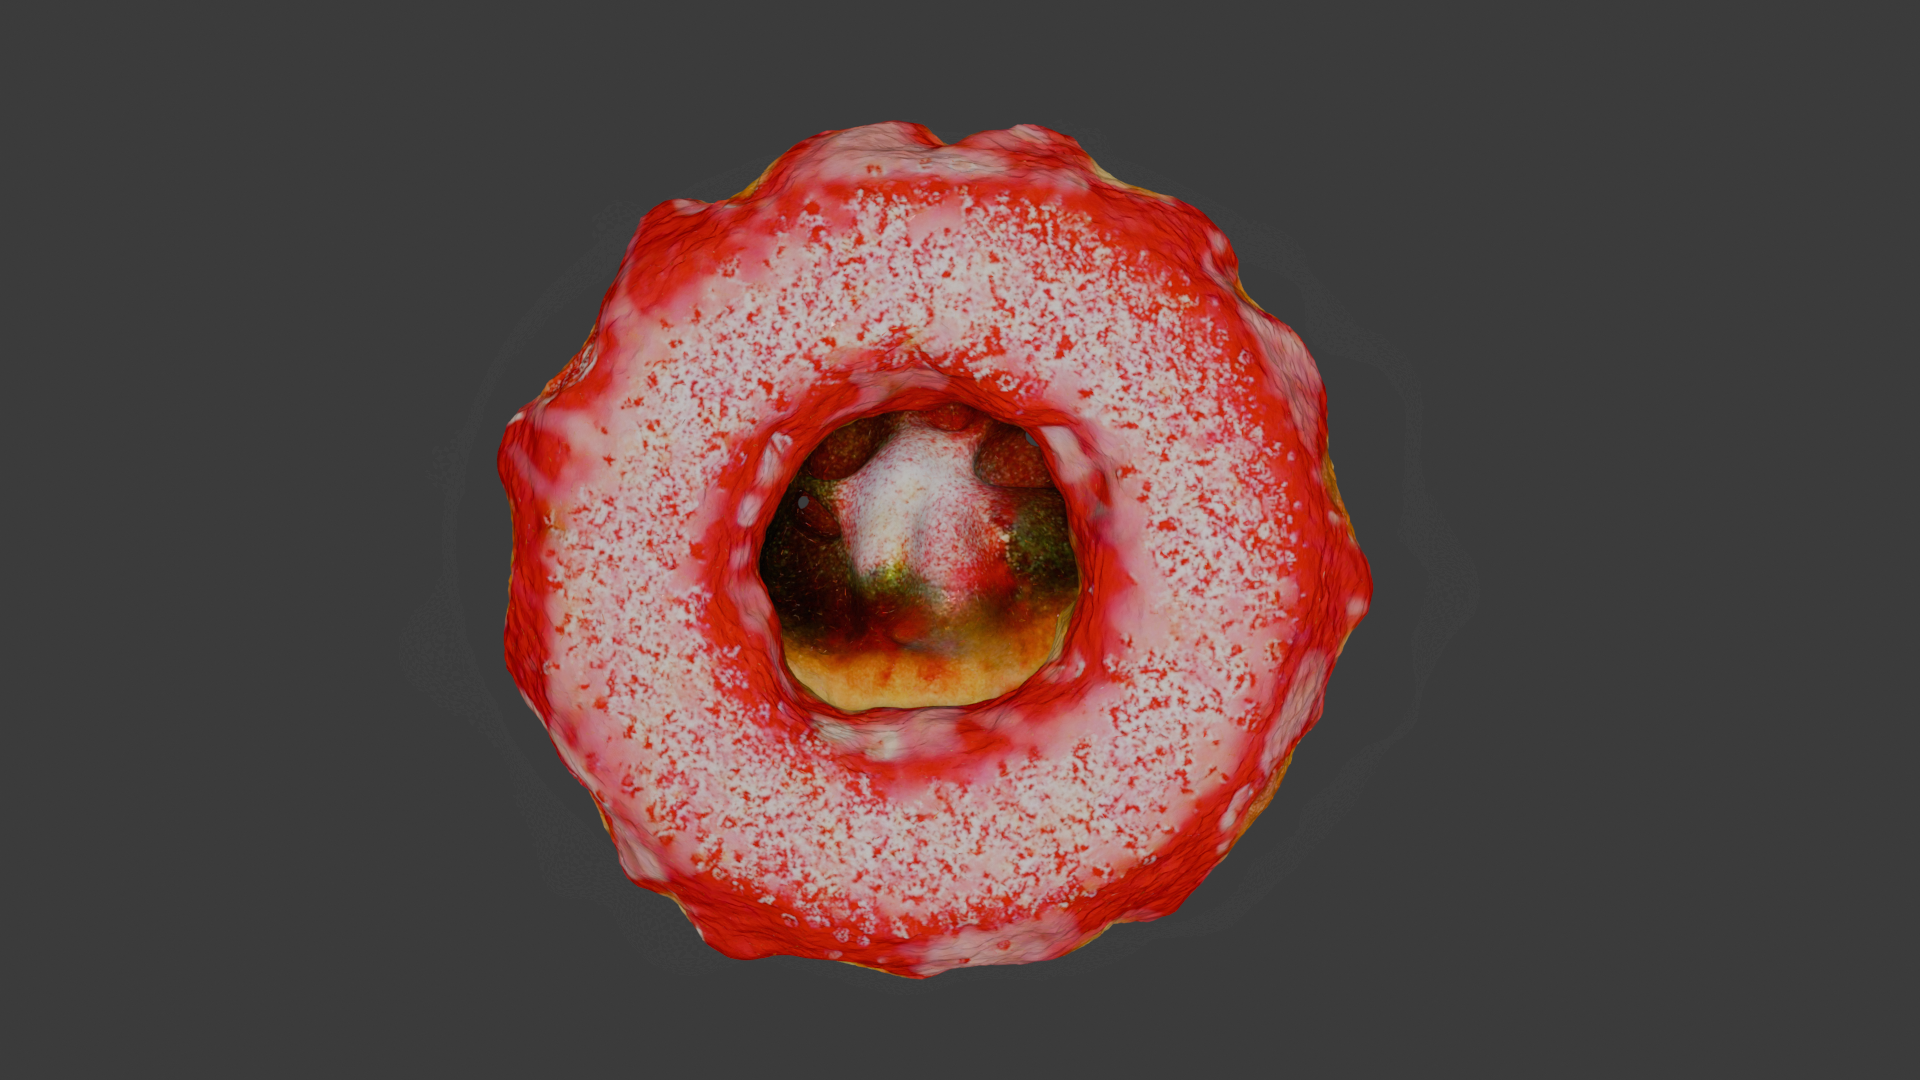